In [1]:
import sys, os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon
import openbabel
import pybel
from pybel import ob
from itertools import combinations
from itertools import chain

Figures and Tables

In [2]:
# Load Files
sets = ['one', 'two', 'three', 'four', 'five', 'six']
early_stop_file =  [pd.read_csv(os.getcwd() + "/result/summary/{}_iter_summary.txt".format(x)) for x in sets]
lowest_point_file =  [pd.read_csv(os.getcwd()+ "/result/summary/{}_lowest_point.txt".format(x)) for x in sets]

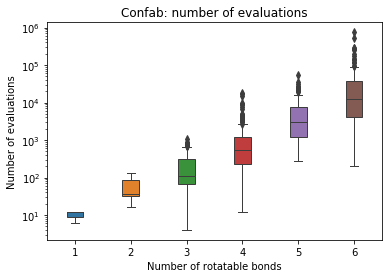

In [3]:
# Number of evaluations in Confab
# Read File and Concatenate
confab = [pd.read_csv(os.getcwd() + "/result/confab_no_evaluation/{}_confab_no.txt".format(x)) for x in sets]
concatenate_confab = pd.concat(confab, axis=0)
no_rot_bonds_list = [[i+1]*len(confab[i]) for i in range(6)]
no_rot_bonds = [item for sublist in no_rot_bonds_list for item in sublist]
concatenate_confab["No_Rotor"] = no_rot_bonds

# Violin Plot
fig, ax = plt.subplots()
ax.set(xscale='linear', yscale="log")
sns.boxplot(data=concatenate_confab, x = "No_Rotor", y = "Number", linewidth=1, width=.3)
plt.xlabel("Number of rotatable bonds")
plt.ylabel(r"Number of evaluations")
plt.title("Confab: number of evaluations")
plt.style
plt.show()

In [4]:
# Load Energy Difference File
seeds = [321, 123, 234, 345, 456] 
seeds_four = [321, 1234,2345,3456,4567]
one_energy = [pd.read_csv(os.getcwd() + "/result/energy/one_{}.txt".format(x)) for x in seeds]
two_energy = [pd.read_csv(os.getcwd() +"/result/energy/two_{}.txt".format(x)) for x in seeds]
three_energy = [pd.read_csv(os.getcwd() + "/result/energy/three_{}.txt".format(x)) for x in seeds]
four_energy = [pd.read_csv(os.getcwd() + "/result/energy/four_{}.txt".format(x)) for x in seeds_four]
five_energy = [pd.read_csv(os.getcwd() + "/result/energy/five_{}.txt".format(x)) for x in seeds]
six_energy = [pd.read_csv(os.getcwd() + "/result/energy/six_{}.txt".format(x)) for x in seeds]



In [5]:
# Energy Table Example
# Uniform / EI / LCB shows the energy difference between 
# lowest energy conformation found by Confab and the conformation found by the 
# BO/uniform search
# MMFF94 is used for energy evaluation
one_energy[1].head()

,Target,Uniform,EI,LCB,N_rot
0,astex_1hq2,1.177558,-0.009270,-0.009201,1
1,astex_1p2y,8.626438,-0.005136,-0.005127,1
2,omegapdb_1xge,6.987051,-1.637241,-1.637272,1
3,astex_1xoz,51.979654,-0.255194,-0.255042,1
4,omegapdb_1yc5,4.691540,-0.041488,-0.041639,1


In [6]:
# Remove mol with early stopping in BO search
def remove_early_stopping(energy_file, early_stop_file):
    temp = list(map(lambda x: pd.merge(x, early_stop_file, on='Target'), energy_file))
    output = list(map(lambda x: x[x["Early_Stop"]== 'No'], temp))
    return output

energy_all =  [one_energy, two_energy, three_energy, four_energy, five_energy, six_energy]
energy_all_clean = []
for indx, item in enumerate(energy_all):
    energy_all_clean.append(remove_early_stopping(item, early_stop_file[indx]))

In [7]:
# Energy Difference
# Use seed 321 for this plot
energy_seed_321 = [item[0] for item in energy_all_clean]

energy_difference = []
for item in energy_seed_321:
    temp = pd.melt(item, id_vars=['N_rot'], value_vars=["EI", "LCB"]) 
    temp.columns = ["N_rot", "Method", "Energy_Difference"]
    energy_difference.append(temp)
                     

energy_difference_frame = pd.concat(energy_difference, axis=0)

In [8]:
uniform_321_median = [item["Uniform"].median() for item in energy_seed_321]
print(uniform_321_median)

[4.1707151248166205, 11.387232329999662, 24.88624008772541, 41.23382363634698, 104.510259249915, 212.90626928800117]


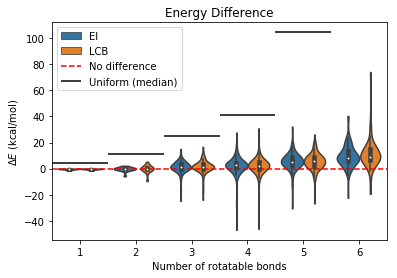

In [9]:
# Plot
sns.violinplot(data=energy_difference_frame, x="N_rot", y="Energy_Difference", hue="Method", cut=0)
# No energy difference
plt.hlines(y=0, xmin=-.5, xmax=8.5, color='red', linestyles= "--", label='No difference') 
# median energy difference (uniform random search)
plt.hlines(y=4.17, xmin=-0.5, xmax=0.5, label="Uniform (median)") # N-rot = 1 
plt.hlines(y=11.39, xmin=0.5, xmax=1.5) # N_rot = 2  
plt.hlines(y=24.89, xmin=1.5, xmax=2.5) # N_rot = 3  
plt.hlines(y=41.23, xmin=2.5, xmax=3.5) # N_rot = 4  
plt.hlines(y=104.51, xmin=3.5, xmax=4.5) #  N_rot = 5  
plt.title("Energy Difference")
plt.legend(loc = 'upper left')
plt.ylabel(r"$\Delta E$ (kcal/mol)")
plt.xlabel("Number of rotatable bonds")
plt.show()

In [10]:
# Percentage of lowest energy conformations found by different algorithms
# 5 x 100 iterations  in Uniform and BO

def count_the_best(x):
    uniform = 0
    confab = 0
    BO = 0
    no_mol = len(x)
    for indx in range(no_mol):
        if x.iloc[indx, 2] == "Yes":
            if "uniform" in x.iloc[indx,1]:
                uniform += 1.0
            if "EI" in x.iloc[indx,1] or "LCB" in x.iloc[indx,1]:
                BO += 1.0
        else:
            confab += 1.0
    
    n_rot = x.iloc[indx, 3]
    return uniform*100.0/no_mol, BO*100.0/no_mol, confab*100.0/no_mol, n_rot # Show percentage

lowest_remove_early_stop = []
for idx in range(6):
    temp = pd.merge(lowest_point_file[idx], early_stop_file[idx], on='Target')
    lowest_remove_early_stop.append(temp[temp["Early_Stop"]=="No"])
    
best_count = list(map(lambda x: count_the_best(x), lowest_remove_early_stop))

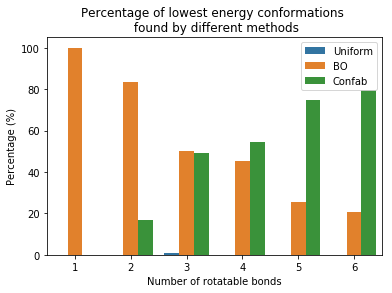

In [11]:
best_count_frame = pd.DataFrame(best_count)
best_count_frame.columns = ["Uniform", "BO", "Confab", "N_rot"]
best_count_frame_reshape = pd.melt(best_count_frame, id_vars="N_rot", value_vars=["Uniform", "BO", "Confab"])
best_count_frame_reshape.columns = ["N_rot", "Methods", "Percentage"]
# Plot
sns.barplot(data=best_count_frame_reshape, x = "N_rot", y = "Percentage", hue = 'Methods')
plt.legend(loc = "upper right")
plt.xlabel("Number of rotatable bonds")
plt.ylabel("Percentage (%)")
plt.title("Percentage of lowest energy conformations \n found by different methods")
plt.show()

In [12]:
# "Champion Rate"
# Percentage of molecules that BO and Uniform search recover in each trial
def count_better_conformation(inputs):
    temp = inputs.iloc[:,1:4] <= 0
    output = temp.sum(axis=0)
    return output

# Count number of better conformations found in each trial
outputs = []
for item in energy_all_clean:
    outputs.append(list(map(lambda x: count_better_conformation(x)*100/len(x), item)))

all_count = []
for indx, item in enumerate(outputs):
    temp = pd.DataFrame(item)
    temp["N_rot"] = indx + 1
    all_count.append(temp)
    
dataframe = []
for item in all_count:
    temp = pd.melt(item, id_vars=['N_rot'], value_vars=["Uniform","EI", "LCB"])
    temp.columns = ["N_rot", "Method", "Percentage"]
    dataframe.append(temp)
    
concatenate_dataframe = pd.concat(dataframe, axis=0)

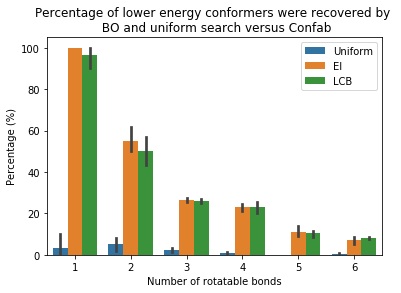

In [13]:
# Plot
sns.barplot(data=concatenate_dataframe, x='N_rot', y='Percentage', hue='Method')
plt.legend(loc = "upper right")
#plt.title()
plt.xlabel("Number of rotatable bonds")
plt.ylabel(r"Percentage (%)")
plt.title("Percentage of lower energy conformers were recovered by \n BO and uniform search versus Confab")
plt.show()

In [14]:
# Wilcoxon Signed Rank Test (Energy Difference)
methods = ["Uniform", "EI", "LCB"]
method_pair = list(combinations(methods, 2))
wilcox_output = []
merge_one_to_three = pd.concat([energy_seed_321[0], energy_seed_321[1], energy_seed_321[2]], axis=0)
energy_for_wilcox_test = [merge_one_to_three, energy_seed_321[3], energy_seed_321[4], energy_seed_321[5]]


for item in energy_for_wilcox_test:
    temp = list(map(lambda x: wilcoxon(item[x[0]], item[x[1]]), method_pair))
    wilcox_output.append(temp)
    
# Wilcoxon Signed Rank Test Table
energy_table = pd.DataFrame(wilcox_output)
energy_table.columns =  method_pair
energy_table.index = ["1_2_3", "4", "5", "6"]
energy_table.index.names = ["N_rot"]
energy_table # (test statistics, p-value)


,"(Uniform, EI)","(Uniform, LCB)","(EI, LCB)"
N_rot,,,
1_2_3,"(61.0, 8.1164594553507e-24)","(34.0, 4.5234244397503416e-24)","(3400.0, 0.024685317609709698)"
4,"(0.0, 4.4596816413765627e-23)","(0.0, 4.4596816413765627e-23)","(3802.0, 0.4381760822507269)"
5,"(9.0, 3.467518300919642e-17)","(11.0, 3.694512617742505e-17)","(2195.0, 0.8875460201293948)"
6,"(3.0, 2.79275975821423e-15)","(1.0, 2.596441359658979e-15)","(1300.0, 0.08963328070679676)"


In [15]:
# Increase number of iterations 
five_200 = [pd.read_csv(os.getcwd() + "/result/energy/five_200_{}.txt".format(x)) for x in [123, 234, 345, 456]]
five_200_early_stop = pd.read_csv(os.getcwd() + "/result/summary/five_200_iter_summary.txt")

merge_5_rot_early_stop = pd.merge(early_stop_file[4], five_200_early_stop, on = 'Target')

keep_5_rotor = []
for indx in merge_5_rot_early_stop.iterrows():
    if indx[1]["Early_Stop_x"] == "No" and indx[1]["Early_Stop_y"] == "No":
        keep_5_rotor.append(True)
    else:
        keep_5_rotor.append(False)

In [16]:
# molecules without early stopping in both 100 and 200 iterations
five_100_123 = five_energy[1][keep_5_rotor]
five_200_123 = five_200[0][keep_5_rotor]


In [17]:
five_combine = pd.concat([five_100_123, five_200_123], join='outer')
five_combine["iteration"] = np.repeat([100, 200], 69)

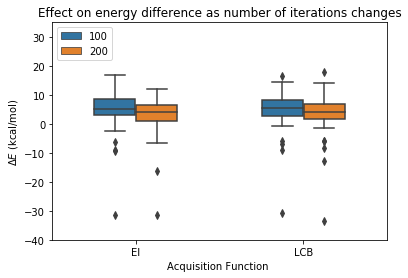

In [18]:
five_combine_melt = pd.melt(five_combine, id_vars=["iteration"], value_vars= ["EI","LCB"])

sns.boxplot(data=five_combine_melt, x = "variable", y = "value", hue = "iteration", width=0.5)
plt.xlabel("Acquisition Function ")
plt.ylabel(r"$\Delta E$ (kcal/mol)")
plt.ylim(-40, 35)
plt.legend(loc = "upper left")
plt.title("Effect on energy difference as number of iterations changes")
plt.show()

In [19]:
print(five_100_123["EI"].median())
print(five_200_123["EI"].median())

print(five_100_123["LCB"].median())
print(five_200_123["LCB"].median())


5.13785369714
3.99295137809
5.36691317762
4.03592971458


In [20]:
# Maximum Variation
def maximum_energy_variation(data):
    EI_variation = data["EI"].max(axis=1) - data["EI"].min(axis=1)
    LCB_variation = data["LCB"].max(axis=1) - data["LCB"].min(axis=1)
    Uniform_variation = data["Uniform"].max(axis=1) - data["Uniform"].min(axis=1)
    
    return EI_variation, LCB_variation, Uniform_variation

In [21]:
all_five_200_concatenate = pd.concat(five_200, axis=1)
all_five_200_remove_early_stop = all_five_200_concatenate[keep_5_rotor]

all_five_100_concatenate = pd.concat(five_energy, axis=1)
all_five_100_remove_early_stop = all_five_100_concatenate[keep_5_rotor]

In [22]:
variation_100 = maximum_energy_variation(all_five_100_remove_early_stop)
variation_200 = maximum_energy_variation(all_five_200_remove_early_stop)

variation_100_frame = pd.DataFrame({"Iterations":100 ,"Methods": np.repeat(["EI", "LCB"], 69), "Variation": list(variation_100[0]) + list(variation_100[1])})
variation_200_frame = pd.DataFrame({"Iterations":200 ,"Methods": np.repeat(["EI", "LCB"], 69), "Variation": list(variation_200[0]) + list(variation_200[1])})
variation_all = pd.concat([variation_100_frame, variation_200_frame])

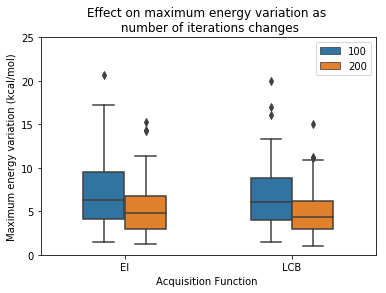

In [23]:
sns.boxplot(data = variation_all, x = "Methods", y = "Variation", hue="Iterations", width=0.5)
plt.ylim(0, 25)
plt.legend(loc = "upper right")
plt.ylabel("Maximum energy variation (kcal/mol)")
plt.xlabel("Acquisition Function ")
plt.title("Effect on maximum energy variation as \n number of iterations changes")
plt.show()

In [24]:
# EI  100, 200 energy variation
print(variation_100[0].median())
print(variation_200[0].median())

# LCB 100, 200 energy variation
print(variation_100[1].median())
print(variation_200[1].median())

6.35124893644
4.85322342747
6.06928260642
4.34185667177


Figures and Tables in Supporting Information

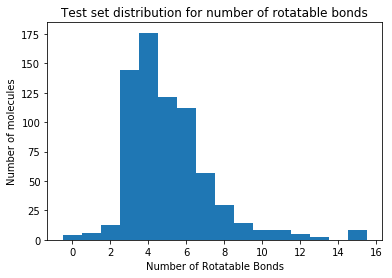

In [25]:
# JP distribution

# Number of Molecules
jpset = []
for mol in pybel.readfile("smi", os.getcwd() + "/molecules/JP_set.smi"):
    jpset.append(mol)

rl = pybel.ob.OBRotorList()
rot_bond_distribution = []
for mol in jpset:
    rl.Setup(mol.OBMol)
    rot_bond_distribution.append(rl.Size())

# Plot 
plt.hist(rot_bond_distribution, bins=16, align='left')
plt.ylabel("Number of molecules")
plt.xlabel("Number of Rotatable Bonds")
plt.title("Test set distribution for number of rotatable bonds")
plt.show()

In [26]:
# Maximum Variation in Energy
merge_energy_frame = [pd.concat(item,axis=1) for item in energy_all_clean]
energy_variation_list = []
for item in merge_energy_frame:
    energy_variation_list.append(maximum_energy_variation(item))

energy_variation_frame = [pd.DataFrame({"Nrot": indx + 1, 
                    "Energy_variation": list(energy_variation_list[indx][0]) + list(energy_variation_list[indx][1]),
                    "Methods": np.repeat(["EI", "LCB"], len(energy_variation_list[indx][0]))}) for indx in range(6)]
concat_variation_frame = pd.concat(energy_variation_frame)

In [27]:
# Uniform Search Energy Variation (Median)
[item[2].median() for item in energy_variation_list]

[8.871887772644225,
 50.25639411406412,
 250.99672266078977,
 453.1100473730423,
 3676.6888308888183,
 6151.392727743794]

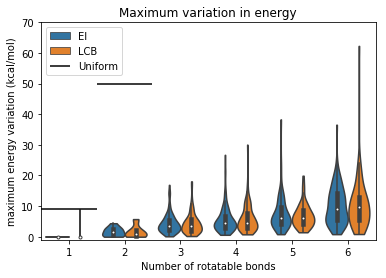

In [28]:
sns.violinplot(data=concat_variation_frame, x="Nrot", y = "Energy_variation", hue="Methods", cut=0)
plt.hlines(y=8.9, xmin=-0.5, xmax=0.5,label = 'Uniform')
plt.hlines(y=50, xmin=0.5 ,xmax=1.5)
plt.ylim(-1,70)
plt.legend(loc = "upper left")
plt.xlabel("Number of rotatable bonds")
plt.ylabel("maximum energy variation (kcal/mol)")
plt.title("Maximum variation in energy")
plt.show()

In [38]:
[item[2].median() for item in energy_variation_list]

[8.871887772644225,
 50.25639411406412,
 250.99672266078977,
 453.1100473730423,
 3676.6888308888183,
 6151.392727743794]

In [29]:
# RMSD 
bo_rmsd = [pd.read_csv(os.getcwd() + "/result/rmsd/{}_bo_rmsd_ref.txt".format(x)) for x in sets]
confab_rmsd = [pd.read_csv(os.getcwd() + "/result/rmsd/{}_confab_rmsd_ref.txt".format(x)) for x in sets]

bo_rmsd_with_early_stopping_info = [pd.merge(bo_rmsd[indx], early_stop_file[indx]) for indx in range(6)]
confab_rmsd_with_early_stopping_info = [pd.merge(confab_rmsd[indx], early_stop_file[indx]) for indx in range(6)]

bo_rmsd_remove_early_stopping = [item[item["Early_Stop"]=="No"] for item in bo_rmsd_with_early_stopping_info]
confab_rmsd_remove_early_stopping = [item[item["Early_Stop"]=="No"] for item in confab_rmsd_with_early_stopping_info]

bo_rmsd_frame = pd.concat(bo_rmsd_remove_early_stopping, sort=False)
confab_rmsd_frame = pd.concat(confab_rmsd_remove_early_stopping, sort=False)

rmsd_case_1 = pd.melt(bo_rmsd_frame, id_vars=["N_rot"], value_vars=["EI", "LCB", "Uniform", "Confab"])
rmsd_case_2 = pd.melt(confab_rmsd_frame, id_vars=["N_rot"], value_vars=["EI", "LCB", "Uniform"])
rmsd_case_1.columns = ["N_rot", "Methods", "RMSD"]
rmsd_case_2.columns = ["N_rot", "Methods", "RMSD"]


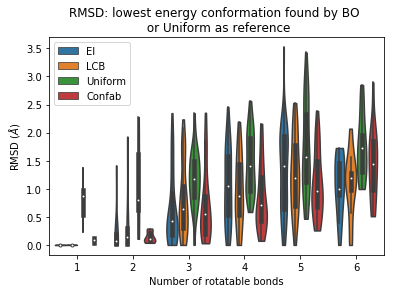

In [30]:
sns.violinplot(data = rmsd_case_1, x = "N_rot", y = "RMSD", hue = "Methods", cut=0)
plt.legend(loc = "upper left")
plt.title("RMSD: lowest energy conformation found by BO \n or Uniform as reference")
plt.ylabel(r"RMSD ($\AA$)")
plt.xlabel("Number of rotatable bonds")
plt.show()

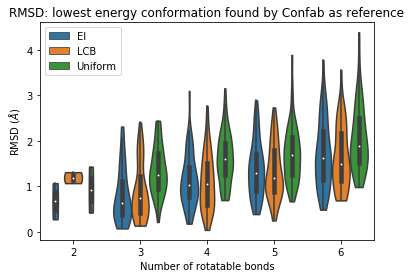

In [31]:
sns.violinplot(data = rmsd_case_2,x = "N_rot", y = "RMSD", hue = "Methods", cut=0)
plt.legend(loc = "upper left")
plt.title("RMSD: lowest energy conformation found by Confab as reference")
plt.ylabel(r"RMSD ($\AA$)")
plt.xlabel("Number of rotatable bonds")
plt.show()

In [32]:
# Wilcoxon Signed Rank Test (RMSD)
# Wilcoxon Signed Rank Test (Energy Difference)
case_1 = ["Uniform", "EI", "LCB", "Confab"]
case_2 = ["Uniform", "EI", "LCB"]
case_1_pair = list(combinations(case_1, 2))
case_2_pair = list(combinations(case_2, 2))
wilcox_output_case_1 = []
wilcox_output_case_2 = []

# Case 1
one_to_three_rmsd_case_1= pd.concat([bo_rmsd_remove_early_stopping[indx] for indx in range(3)], axis=0)
five_to_six_rmsd_case_1 = pd.concat([bo_rmsd_remove_early_stopping[indx] for indx in range(4,6)])
case_1_rmsd = [one_to_three_rmsd_case_1, bo_rmsd_remove_early_stopping[3], five_to_six_rmsd_case_1]
one_to_three_rmsd_case_2 = pd.concat([bo_rmsd_remove_early_stopping[indx] for indx in range(3)], axis=0)
case_2_rmsd = [one_to_three_rmsd_case_2] + [bo_rmsd_remove_early_stopping[indx] for indx in range(3,6)]

for item in case_1_rmsd:
    temp = list(map(lambda x: wilcoxon(item[x[0]], item[x[1]]), case_1_pair))
    wilcox_output_case_1.append(temp)

    
for item in case_2_rmsd:
    temp = list(map(lambda x: wilcoxon(item[x[0]], item[x[1]]), case_2_pair))
    wilcox_output_case_2.append(temp)
    
# Wilcoxon Signed Rank Test Table
rmsd_case_1_table = pd.DataFrame(wilcox_output_case_1)
rmsd_case_2_table = pd.DataFrame(wilcox_output_case_2)
rmsd_case_1_table.columns =  case_1_pair
rmsd_case_2_table.columns =  case_2_pair

rmsd_case_1_table.index = ["1_2_3", "4", "5_6"]
rmsd_case_2_table.index = ["1_2_3", "4", "5", "6"]

rmsd_case_1_table.index.names = ["N_rot"]
rmsd_case_2_table.index.names = ["N_rot"]

In [33]:
rmsd_case_1_table

,"(Uniform, EI)","(Uniform, LCB)","(Uniform, Confab)","(EI, LCB)","(EI, Confab)","(LCB, Confab)"
N_rot,,,,,,
1_2_3,"(267.0, 3.654026587899751e-10)","(487.0, 2.589765160970065e-07)","(334.0, 3.0675349144891e-09)","(1061.0, 0.025310911559474417)","(1087.0, 0.035325264900773895)","(1410.0, 0.6422263635292849)"
4,"(356.0, 6.527580218994658e-05)","(286.0, 6.147913220903827e-06)","(176.0, 8.72209226556705e-08)","(798.0, 0.6561860590200659)","(614.0, 0.04080544253847339)","(729.0, 0.23900227942500074)"
5_6,"(344.0, 0.001006147574359149)","(260.0, 5.52020539498103e-05)","(287.0, 0.00014859271900741355)","(689.0, 1.0)","(603.0, 0.31928123262439656)","(677.0, 0.7332304819322608)"


In [34]:
rmsd_case_2_table

,"(Uniform, EI)","(Uniform, LCB)","(EI, LCB)"
N_rot,,,
1_2_3,"(267.0, 3.654026587899751e-10)","(487.0, 2.589765160970065e-07)","(1061.0, 0.025310911559474417)"
4,"(356.0, 6.527580218994658e-05)","(286.0, 6.147913220903827e-06)","(798.0, 0.6561860590200659)"
5,"(212.0, 0.05730468909396958)","(145.0, 0.0031410295159242513)","(312.0, 0.9608097754501559)"
6,"(14.0, 0.003090081924360667)","(17.0, 0.004853230851379527)","(70.0, 0.7583123742610346)"


In [35]:
# TFD Plot
bo_tfd = [pd.read_csv(os.getcwd() + "/result/tfd/{}_bo_tfd_ref.txt".format(x)) for x in sets]
confab_tfd = [pd.read_csv(os.getcwd() + "/result/tfd/{}_confab_tfd_ref.txt".format(x)) for x in sets]

bo_tfd_with_early_stopping_info = [pd.merge(bo_tfd[indx], early_stop_file[indx]) for indx in range(6)]
confab_tfd_with_early_stopping_info = [pd.merge(confab_tfd[indx], early_stop_file[indx]) for indx in range(6)]

bo_tfd_remove_early_stopping = [item[item["Early_Stop"]=="No"] for item in bo_tfd_with_early_stopping_info]
confab_tfd_remove_early_stopping = [item[item["Early_Stop"]=="No"] for item in confab_tfd_with_early_stopping_info]

bo_tfd_frame = pd.concat(bo_tfd_remove_early_stopping, sort=False)
confab_tfd_frame = pd.concat(confab_tfd_remove_early_stopping, sort=False)

tfd_case_1 = pd.melt(bo_tfd_frame, id_vars=["N_rot"], value_vars=["EI", "LCB", "Uniform", "Confab"])
tfd_case_2 = pd.melt(confab_tfd_frame, id_vars=["N_rot"], value_vars=["EI", "LCB", "Uniform"])
tfd_case_1.columns = ["N_rot", "Methods", "tfd"]
tfd_case_2.columns = ["N_rot", "Methods", "tfd"]


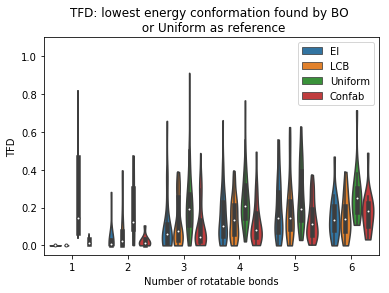

In [36]:
sns.violinplot(data = tfd_case_1, x = "N_rot", y = "tfd", hue = "Methods", cut=0)
plt.legend(loc = "upper right")
plt.title("TFD: lowest energy conformation found by BO \n or Uniform as reference")
plt.ylabel("TFD")
plt.xlabel("Number of rotatable bonds")
plt.ylim(-0.05,1.1)
plt.show()

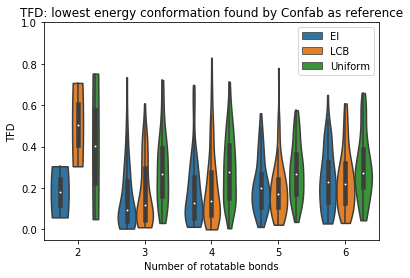

In [37]:
sns.violinplot(data = tfd_case_2,x = "N_rot", y = "tfd", hue = "Methods", cut=0)
plt.legend(loc = "upper right")
plt.title("TFD: lowest energy conformation found by Confab as reference")
plt.ylabel("TFD")
plt.xlabel("Number of rotatable bonds")
plt.ylim(-.05, 1)
plt.show()

In [38]:
# Wilcoxon Signed Rank Test (TFD)
# Wilcoxon Signed Rank Test (Energy Difference)
case_1 = ["Uniform", "EI", "LCB", "Confab"]
case_2 = ["Uniform", "EI", "LCB"]
case_1_pair = list(combinations(case_1, 2))
case_2_pair = list(combinations(case_2, 2))
wilcox_output_case_1 = []
wilcox_output_case_2 = []

# Case 1
one_to_three_tfd_case_1= pd.concat([bo_tfd_remove_early_stopping[indx] for indx in range(3)], axis=0)
five_to_six_tfd_case_1 = pd.concat([bo_tfd_remove_early_stopping[indx] for indx in range(4,6)])
case_1_tfd = [one_to_three_tfd_case_1, bo_tfd_remove_early_stopping[3], five_to_six_tfd_case_1]
one_to_three_tfd_case_2 = pd.concat([bo_tfd_remove_early_stopping[indx] for indx in range(3)], axis=0)
case_2_tfd = [one_to_three_tfd_case_2] + [bo_tfd_remove_early_stopping[indx] for indx in range(3,6)]

for item in case_1_tfd:
    temp = list(map(lambda x: wilcoxon(item[x[0]], item[x[1]]), case_1_pair))
    wilcox_output_case_1.append(temp)

    
for item in case_2_tfd:
    temp = list(map(lambda x: wilcoxon(item[x[0]], item[x[1]]), case_2_pair))
    wilcox_output_case_2.append(temp)
    
# Wilcoxon Signed Rank Test Table
tfd_case_1_table = pd.DataFrame(wilcox_output_case_1)
tfd_case_2_table = pd.DataFrame(wilcox_output_case_2)
tfd_case_1_table.columns =  case_1_pair
tfd_case_2_table.columns =  case_2_pair

tfd_case_1_table.index = ["1_2_3", "4", "5_6"]
tfd_case_2_table.index = ["1_2_3", "4", "5", "6"]

tfd_case_1_table.index.names = ["N_rot"]
tfd_case_2_table.index.names = ["N_rot"]

In [39]:
tfd_case_1_table

,"(Uniform, EI)","(Uniform, LCB)","(Uniform, Confab)","(EI, LCB)","(EI, Confab)","(LCB, Confab)"
N_rot,,,,,,
1_2_3,"(381.0, 1.2755988525709215e-08)","(539.0, 1.0235188529257314e-06)","(298.0, 9.917549312463542e-10)","(1140.0, 0.06643100054027701)","(1425.0, 0.6977006407392807)","(1212.0, 0.14158160978783632)"
4,"(322.0, 2.1423819215552174e-05)","(322.0, 2.1423819215552174e-05)","(280.0, 4.958748234166251e-06)","(846.0, 0.9413666226561762)","(687.0, 0.13504517961739332)","(699.0, 0.16034162164665688)"
5_6,"(308.0, 0.00030915965211295005)","(322.0, 0.0004947868791670605)","(214.0, 9.010049806711219e-06)","(653.0, 0.7430258351305743)","(550.0, 0.1428847589521032)","(587.0, 0.25529579578327)"


In [40]:
tfd_case_2_table

,"(Uniform, EI)","(Uniform, LCB)","(EI, LCB)"
N_rot,,,
1_2_3,"(381.0, 1.2755988525709215e-08)","(539.0, 1.0235188529257314e-06)","(1140.0, 0.06643100054027701)"
4,"(322.0, 2.1423819215552174e-05)","(322.0, 2.1423819215552174e-05)","(846.0, 0.9413666226561762)"
5,"(175.0, 0.013054800767811299)","(155.0, 0.005166223468725871)","(284.0, 0.611626271347183)"
6,"(23.0, 0.011322371449485434)","(32.0, 0.03515697309591544)","(74.0, 0.9057940914405992)"
